In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import neurokit2 as nk

sys.path.append('..')
from util import standardize_signal, normalize_signal, load_base_data

import warnings
warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = [20, 5]

In [5]:
DATA_PATH = "../data"
SAMPLING_RATE = 300

In [8]:
X_train, y_train, X_test = load_base_data(data_path=DATA_PATH, just_train=False, flip=True, standard=True)

# Sandbox

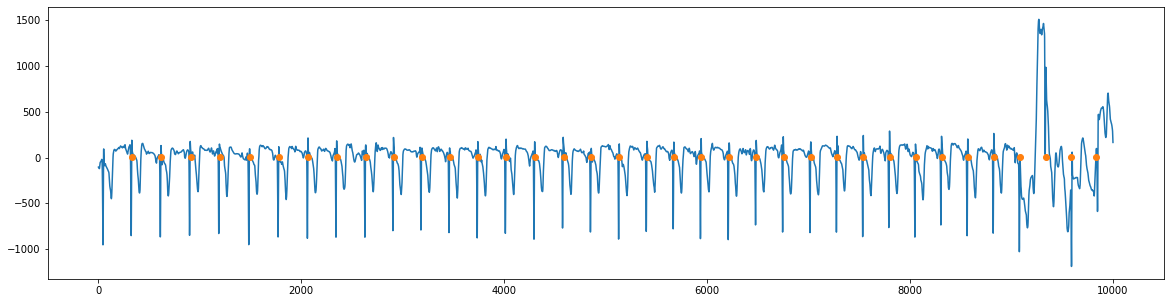

[310, 597, 880, 1168, 1469, 1746, 2043, 2331, 2604, 2885, 3170, 3440, 3723, 3999, 4283, 4558, 4831, 5112, 5385, 5653, 5925, 6198, 6461, 6734, 7002, 7261, 7516, 7776, 8032, 8288, 8553, 8808, 9053, 9271, nan, nan]
[ 332  619  908 1197 1492 1780 2068 2351 2636 2912 3190 3466 3743 4021
 4303 4585 4860 5137 5410 5675 5944 6219 6487 6754 7025 7284 7542 7801
 8058 8315 8573 8829 9087 9342 9584 9838]


In [33]:
i = 2000

signal = X_train.loc[i].dropna().to_numpy(dtype='float32')

signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
rpeaks = info["ECG_R_Peaks"]
cleaned_signal = signals["ECG_Clean"]

_, waves_peak = nk.ecg_delineate(cleaned_signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")

plt.plot(signal)
#plt.plot(waves_peak['ECG_P_Peaks'], np.ones(len(waves_peak['ECG_P_Peaks'])), 'o')
plt.plot(rpeaks, np.ones(len(rpeaks)), 'o')
plt.show()

print(waves_peak['ECG_P_Peaks'])
print(rpeaks)
# for key in waves_peak.keys():



In [19]:
def intervals_mean_std(l1, l2):
    length = min(len(l1), len(l2))
    intervals = np.array(l2[:length])-np.array(l1[:length])
    return np.mean(intervals[~np.isnan(intervals)]), np.std(intervals[~np.isnan(intervals)])

def get_feature_mean_std(points, signal):
    vals = []
    for i in [p for p in points if p is not np.nan]:
        vals.append(signal[i])
    return np.mean(vals), np.std(vals)

def generate_rpqst_feature_vector(r_peaks, signal, waves_peak):
    feature = []
    r_peaks_mean, r_peaks_std = get_feature_mean_std(r_peaks, signal)
    feature.append(r_peaks_mean)
    feature.append(r_peaks_std)
    for key in waves_peak.keys():
        mean, std = get_feature_mean_std(waves_peak[key], signal)
        feature.append(mean)
        feature.append(std)
    return feature

def generate_interval_features(data):
    keys = ['ECG_P_Peaks', 'ECG_Q_Peaks', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_P_Onsets', 'ECG_T_Offsets']
    feature_names = [
        'r_peaks_mean', 'r_peaks_std', 
        'p_peaks_mean', 'p_peaks_std', 'q_peaks_mean', 'q_peaks_std',
        's_peaks_mean', 's_peaks_std', 't_peaks_mean', 't_peaks_std',
        'p_onsets_mean', 'p_onsets_std', 't_offsets_mean', 't_offsets_std'] + ['pr_mean', 'pr_std', 
            'qr_mean', 'qr_std',
            'sr_mean', 'sr_std',
            'tr_mean', 'tr_std',
            'por_mean', 'por_std',
            'tor_mean', 'tor_std',
        ]
    feature_vecs = []
#     indices = []
    error_counts = 0
    for i in tqdm(range(len(data))):
        signal = data.loc[i].dropna().to_numpy(dtype='float32')
#         feature_vector = None

        try:
            signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
            rpeaks = info["ECG_R_Peaks"]
            cleaned_signal = signals["ECG_Clean"]
            _, waves_peak = nk.ecg_delineate(cleaned_signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")

        except:
            print("Could not run ecg_process.")
            signal = 1-signal
            signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
            rpeaks = info["ECG_R_Peaks"]
            cleaned_signal = signals["ECG_Clean"]
            _, waves_peak = nk.ecg_delineate(cleaned_signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")
        
        rpqst_feature_vector = generate_rpqst_feature_vector(rpeaks, signal, waves_peak)
            
        intervals_stats = []
        for k in keys:
            mean, std = intervals_mean_std(waves_peak[k], rpeaks)
            intervals_stats.append(mean)
            intervals_stats.append(std)
        interval_feature_vector = intervals_stats
        
        feature_vector = rpqst_feature_vector + interval_feature_vector
        
        feature_vecs.append(feature_vector)
            
#         if feature_vector is None:
#             error_counts += 1
#             feature_vector = [np.nan]*len(feature_names)
#         feature_vecs.append(feature_vector)
#         indices.append(i)
        
    return feature_names, np.array(feature_vecs), error_counts

In [20]:
feature_names, features, error_counts = generate_interval_features(X_train)

 19%|█████████████▋                                                           | 963/5117 [03:24<18:06,  3.82it/s]

Could not run ecg_process.


 24%|█████████████████▌                                                      | 1248/5117 [04:24<12:24,  5.20it/s]

Could not run ecg_process.


 33%|████████████████████████                                                | 1713/5117 [06:04<11:26,  4.96it/s]

Could not run ecg_process.


 34%|████████████████████████▊                                               | 1765/5117 [06:15<08:16,  6.75it/s]

Could not run ecg_process.


 51%|████████████████████████████████████▍                                   | 2592/5117 [09:09<09:20,  4.50it/s]

Could not run ecg_process.


 71%|███████████████████████████████████████████████████▎                    | 3648/5117 [12:48<05:24,  4.53it/s]

Could not run ecg_process.


 82%|███████████████████████████████████████████████████████████▏            | 4204/5117 [14:42<02:58,  5.13it/s]

Could not run ecg_process.


 90%|████████████████████████████████████████████████████████████████▌       | 4588/5117 [21:21<01:43,  5.09it/s]

Could not run ecg_process.


 97%|█████████████████████████████████████████████████████████████████████▋  | 4954/5117 [22:39<00:31,  5.17it/s]

Could not run ecg_process.


100%|████████████████████████████████████████████████████████████████████████| 5117/5117 [23:15<00:00,  3.67it/s]


In [22]:
fd_X_train_df = pd.DataFrame(features, columns = feature_names)
fd_X_train_df.to_csv("X_train.csv", index_label="id")

In [ ]:
feature_names, features, error_counts = generate_interval_features(X_test)

In [ ]:
fd_X_test_df = pd.DataFrame(features, columns = feature_names)
fd_X_test_df.to_csv("X_test.csv", index_label="id")